# Overfitting Or When Your Model Tries Too Hard to Please

In [1]:
import random
import json
import gzip
from itertools import product
import subprocess

import numpy as np

# DataViz
import matplotlib.pyplot as plt

# SKLearn Tools
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# ML Models
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# Utils
from tqdm.notebook import tqdm
from celluloid import Camera
from IPython.display import HTML

In [2]:
# matplotlib Color Setup
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Dracula Color Palette
COL_Background = '#272934'
COL_Selection = '#44475a'
COL_Foreground = '#f8f8f2'
COL_Comment = '#6272a4'
COL_Cyan = '#8be9fd'
COL_Green = '#50fa7b'
COL_Orange = '#ffb86c'
COL_Pink = '#ff79c6'
COL_Purple = '#bd93f9'
COL_Red = '#ff5555'
COL_Yellow = '#f1fa8c'

sequential_cmap = LinearSegmentedColormap.from_list(
    'custom_sequential', [COL_Comment, COL_Purple]
)

diverging_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging', [COL_Cyan, COL_Comment, COL_Purple]
)

categorical_cmap = ListedColormap([COL_Cyan, COL_Green, COL_Orange, COL_Pink, COL_Purple, COL_Red, COL_Yellow])

plt.rcParams.update({
    'figure.facecolor': COL_Background,
    'axes.facecolor': COL_Background,
    'axes.edgecolor': COL_Background,
    'axes.labelcolor': COL_Comment,
    'text.color': COL_Comment,
    'xtick.color': COL_Comment,
    'ytick.color': COL_Comment,
    'grid.color': COL_Selection
})

In [3]:
SEED = 2

## 1. A Gentle Start: Fitting Curves with Polynomials

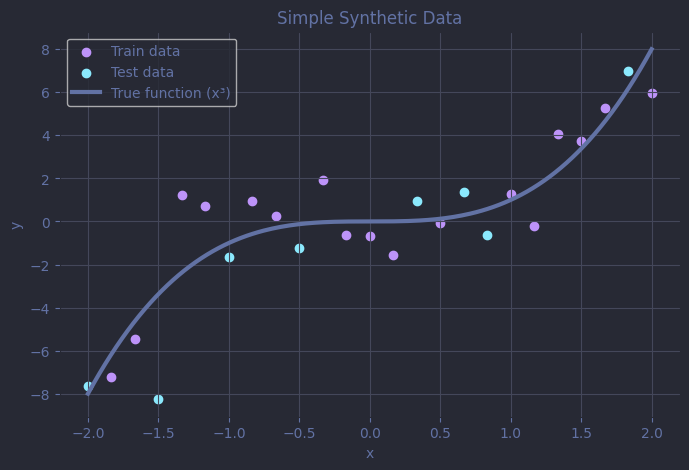

In [5]:
rng = np.random.default_rng(SEED)

X = np.linspace(-2, 2, 25)
y = (X ** 3) + rng.normal(0, 2, size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

X_plot = np.linspace(-2, 2, 200)
y_plot_true = X_plot ** 3

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
X_plot = X_plot.reshape(-1, 1)

# Visualisation
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, color=COL_Purple, label='Train data')
plt.scatter(X_test, y_test, color=COL_Cyan, label='Test data')
plt.plot(X_plot, y_plot_true, color=COL_Comment, linewidth=3, label='True function (x³)')
plt.title("Simple Synthetic Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig('simple_synthetic_data.png')
plt.show()

In [6]:
degrees = list(range(1, 17))
results = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    X_plot_poly = poly.transform(X_plot)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot_pred = model.predict(X_plot_poly)

    results.append({
        "degree": degree,
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "test_mae": mean_absolute_error(y_test, y_test_pred),
        "y_plot_pred": y_plot_pred
    })

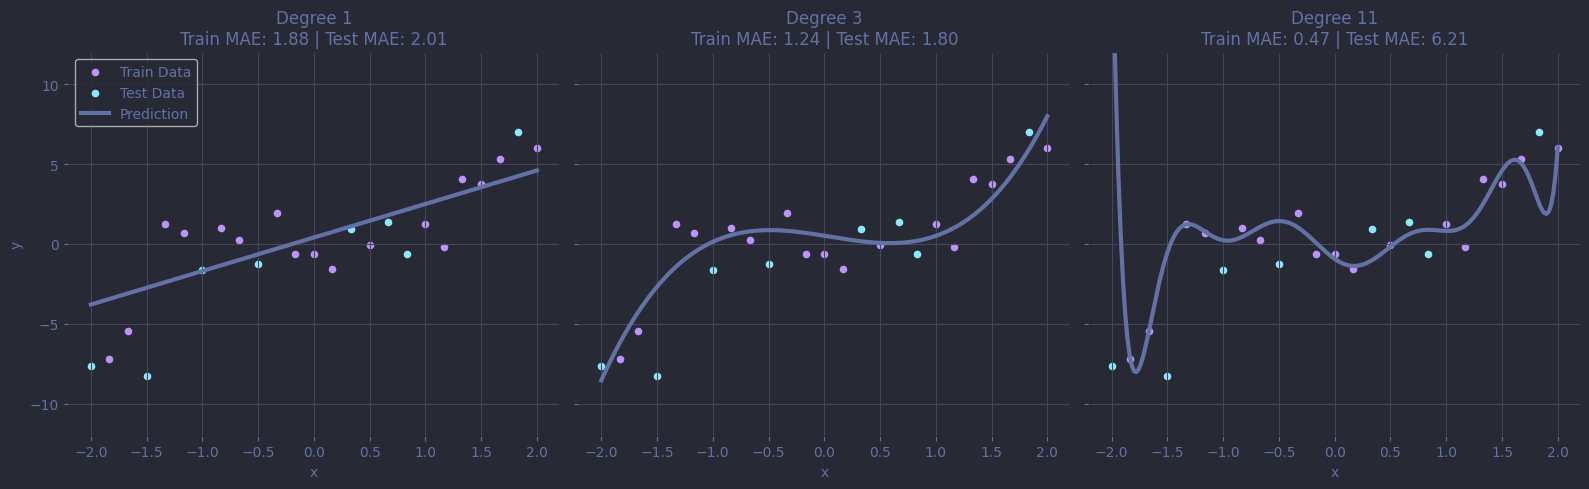

In [14]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
for ax, degree in zip(axes, [1, 3, 11]):
    result = next(r for r in results if r["degree"] == degree)

    ax.scatter(X_train, y_train, color=COL_Purple, label='Train Data', s=20)
    ax.scatter(X_test, y_test, color=COL_Cyan, label='Test Data', s=20)
    
    ax.plot(X_plot, result["y_plot_pred"], color=COL_Comment, linewidth=3, label=f'Prediction')

    ax.set_title(f"Degree {degree}\nTrain MAE: {result['train_mae']:.2f} | Test MAE: {result['test_mae']:.2f}")
    ax.set_xlabel("x")
    ax.grid(True)

axes[0].set_ylim(-12, 12)
axes[0].set_ylabel("y")
axes[0].legend(loc='upper left')
plt.tight_layout()
plt.savefig('degree_compared.png')
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Generating Video...


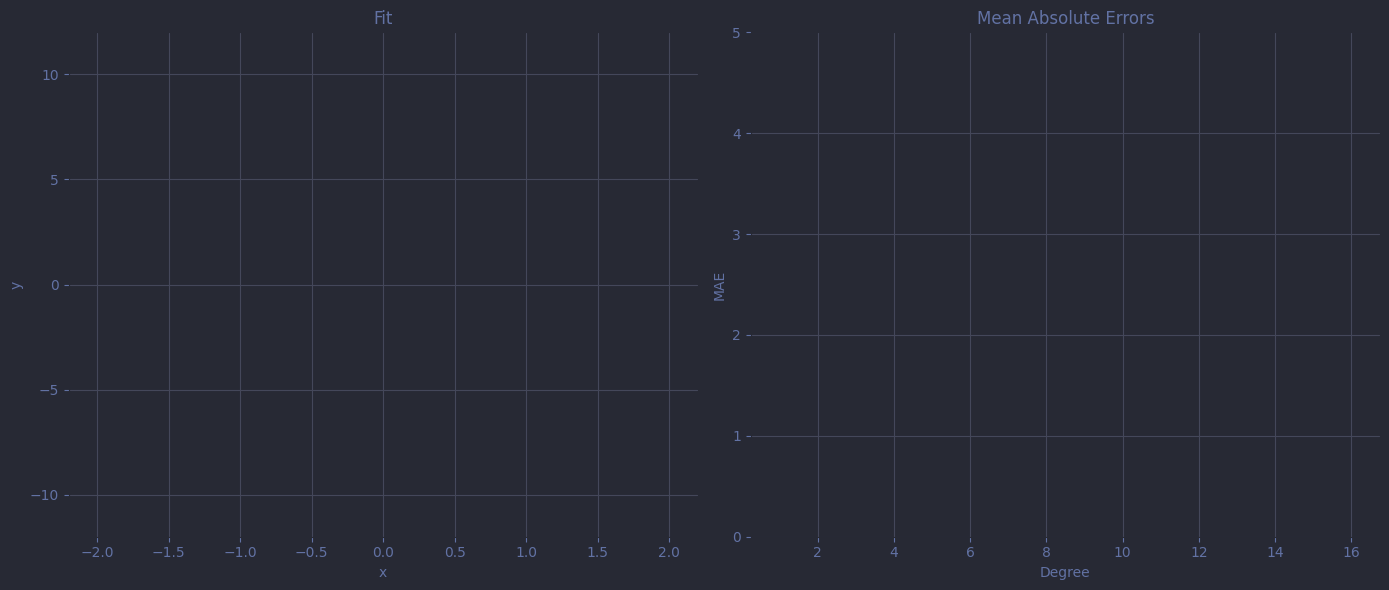

In [8]:
# Visualisation - Animation
degrees = [r["degree"] for r in results]
train_maes = [r["train_mae"] for r in results]
test_maes = [r["test_mae"] for r in results]

fig, (ax_fit, ax_mae) = plt.subplots(1, 2, figsize=(14, 6))
camera = Camera(fig)

looping_results = results + results[-2::-1]

for result, next_result in tqdm(zip(looping_results[:-1], looping_results[1:]), total = len(looping_results) - 1):
    d1 = result["degree"]
    y1 = result["y_plot_pred"]
    d2 = next_result["degree"]
    y2 = next_result["y_plot_pred"]

    nb_inter_steps = int(-0.1 * (d1**2) + 0.6*d1 + 20)
    
    for step in np.linspace(0, 1, nb_inter_steps):
        interp_degree = d1 + step if d2 > d1 else d1 - step
        interp_y = (1 - step) * y1 + step * y2
        
        # Left: Prediction plot
        ax_fit.scatter(X_train, y_train, color=COL_Purple, s=20)
        ax_fit.scatter(X_test, y_test, color=COL_Cyan, s=20)
        ax_fit.plot(X_plot, y_plot_true, color=COL_Comment, linewidth=1)
        ax_fit.plot(X_plot, interp_y, color=COL_Pink, linewidth=3)
        ax_fit.text(-1.5, 10, f"x^{d1}  ", color=COL_Comment, fontsize=12, ha='right', va='bottom')
        ax_fit.set_ylim(-12, 12)
        ax_fit.set_title('Fit')
        ax_fit.set_xlabel("x")
        ax_fit.set_ylabel("y")
        ax_fit.grid(True)
    
        # Right: MAE over degrees
        ax_mae.plot(degrees, train_maes, label='Train MAE', color=COL_Purple)
        ax_mae.plot(degrees, test_maes, label='Test MAE', color=COL_Cyan)
        ax_mae.axvline(x=interp_degree, color=COL_Comment, linestyle='--')
        ax_mae.text(16, 5, "Test Data", color=COL_Cyan, fontsize=10, ha='right', va='top')
        ax_mae.text(16, 0, "Train Data", color=COL_Purple, fontsize=10, ha='right', va='bottom')
        ax_mae.text(interp_degree, 4, f"x^{d1}  ", color=COL_Comment, fontsize=10, ha='right', va='bottom')
        ax_mae.set_title('Mean Absolute Errors')
        ax_mae.set_xlabel("Degree")
        ax_mae.set_ylabel("MAE")
        ax_mae.set_ylim(0, 5)
        ax_mae.grid(True)
    
        plt.tight_layout()
        
        camera.snap()

print('Generating Video...')
animation = camera.animate(interval=33, repeat=False)
animation.save('fit_animation.mp4')
HTML(animation.to_html5_video())



## 2. From Curve Fitting to Income Prediction

### Simulating Real-World Data (Sort Of)

In [15]:
def income(age, rng=None):
    # income
    if age < 12:
        income = 0
    elif age < 18:
        income = (15000 / 18) * age
    elif age < 30:
        income = 15000 + 50000 * ((age - 18) / 14) ** 1.5
    elif age < 60:
        income = 55000 + 350 * (age - 30)
    else:
        income = 65000 - 10000 * (1 - np.exp(-0.05 * (age - 60)))

    # noise
    if age < 18:
        noise_factor = np.clip((age - 12) / 6, 0, 1)
    elif age > 60:
        noise_factor = np.clip((90 - age) / 30, 0, 1)
    else:
        noise_factor = 1
    
    income += rng.normal(0, noise_factor * 10000) if rng else 0
    return income if income > 0 else 0

# Realistic sampling with noise
rng = np.random.default_rng(SEED)
age_train = []

while len(age_train) < 1000:
    new_vals = np.random.normal(loc=40, scale=18, size=1000 - len(age_train))
    age_train.extend(new_vals[(new_vals >= 0) & (new_vals <= 90)])

income_train = [income(x, rng=rng) for x in age_train]

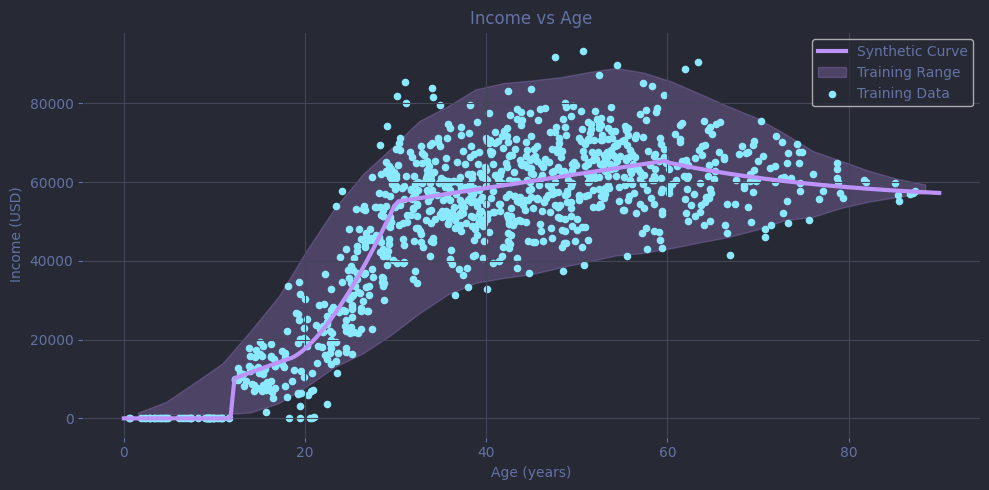

In [16]:
# Visualization
# bin income data by age
bin_edges = np.linspace(0, 90, 30)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_min = []
bin_max = []

for start, end in zip(bin_edges[:-1], bin_edges[1:]):
    incomes_in_bin = np.array(income_train)[(age_train >= start) & (age_train < end)]
    
    if len(incomes_in_bin) > 0:
        bin_min.append(incomes_in_bin.min())
        bin_max.append(incomes_in_bin.max())
    else:
        bin_min.append(np.nan)
        bin_max.append(np.nan)

bin_min_smooth = np.convolve(np.pad(np.nan_to_num(bin_min, nan=np.nanmean(bin_min)), 3, mode='edge'), np.ones(7)/7, mode='valid')
bin_max_smooth = np.convolve(np.pad(np.nan_to_num(bin_max, nan=np.nanmean(bin_max)), 3, mode='edge'), np.ones(7)/7, mode='valid')

# synthetic curve
age_synthetic = np.linspace(0, 90, 200)
income_synthetic = [income(age) for age in age_synthetic]

plt.figure(figsize=(10, 5))
plt.plot(age_synthetic, income_synthetic, label="Synthetic Curve", color=COL_Purple, linewidth=3)
plt.fill_between(bin_centers, bin_min_smooth, bin_max_smooth, color=COL_Purple, alpha=0.25, label="Training Range")
plt.scatter(age_train, income_train, label="Training Data", color=COL_Cyan, s=20)
plt.xlabel("Age (years)")
plt.ylabel("Income (USD)")
plt.title("Income vs Age")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('better_synthetic_data.png')
plt.show()

### One Dataset, Three Very Different Fits

In [17]:
common_params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'min_sum_hessian_in_leaf': 0,
    'verbosity': -1,
    'seed': SEED,
}

train_dataset = lgb.Dataset(
    np.array(age_train).reshape(-1, 1),
    label = income_train
)

# Overfitting Model
overfit_params = {
    'num_leaves': 256,
    'num_iterations': 1000,
    'min_data_in_leaf': 1,
}
overfit_model = lgb.train(common_params | overfit_params, train_dataset)
print('Trained Overfitting Model')

# Underfit Model
underfit_params = {
    'num_leaves': 2,
    'num_iterations': 25,
}
underfit_model = lgb.train(common_params | underfit_params, train_dataset)
print('Trained Underfitting Model')

# Regularized Model
param_grid = {
    'num_leaves': [4, 8, 16],
    'min_data_in_leaf': [10, 15, 20, 25, 30],
    'lambda_l2': [0, 10, 20, 30, 40, 50],
}
total_iter = np.prod([len(v) for v in param_grid.values()])

best_score = float('inf')
best_params = None

for nl, mdl, l2, in tqdm(product(
    param_grid['num_leaves'],
    param_grid['min_data_in_leaf'],
    param_grid['lambda_l2'],
), total=total_iter):
    params = common_params | {'num_leaves': nl, 'min_data_in_leaf': mdl, 'lambda_l2': l2,}

    cv_result = lgb.cv(
        params | {'num_iterations': 10000, 'early_stopping_rounds': 50},
        train_dataset,
        nfold=5,
        stratified=False,
        seed=SEED,
    )

    mean_mae = cv_result['valid l1-mean'][-1]
    
    if mean_mae < best_score:
        best_score = mean_mae
        best_params = params | {'num_iterations' : len(cv_result['valid l1-mean'])}
        
regularized_model = lgb.train(best_params, train_dataset)

print('Trained Regularized Model')
for name, param in best_params.items():
    print(f'\t{name} : {param}')

Trained Overfitting Model
Trained Underfitting Model


  0%|          | 0/90 [00:00<?, ?it/s]

Trained Regularized Model
	objective : regression
	metric : mae
	learning_rate : 0.05
	min_sum_hessian_in_leaf : 0
	verbosity : -1
	seed : 2
	num_leaves : 4
	min_data_in_leaf : 30
	lambda_l2 : 10
	num_iterations : 167


In [18]:
# Predictions

ages_to_predict = np.linspace(0, 90, 1000)
income_without_noise = [income(age) for age in ages_to_predict]

# Overfitting Model
predicted_incomes_overfit = overfit_model.predict(ages_to_predict.reshape(-1, 1))
mae_overfit = mean_absolute_error(income_without_noise, predicted_incomes_overfit)

# Underfitting Model
predicted_incomes_underfit = underfit_model.predict(ages_to_predict.reshape(-1, 1))
mae_underfit = mean_absolute_error(income_without_noise, predicted_incomes_underfit)

# Regularized Model
predicted_incomes_regularized = regularized_model.predict(ages_to_predict.reshape(-1, 1))
mae_regularized = mean_absolute_error(income_without_noise, predicted_incomes_regularized)

### Overfit, Underfit, Just-Right: The Visuals

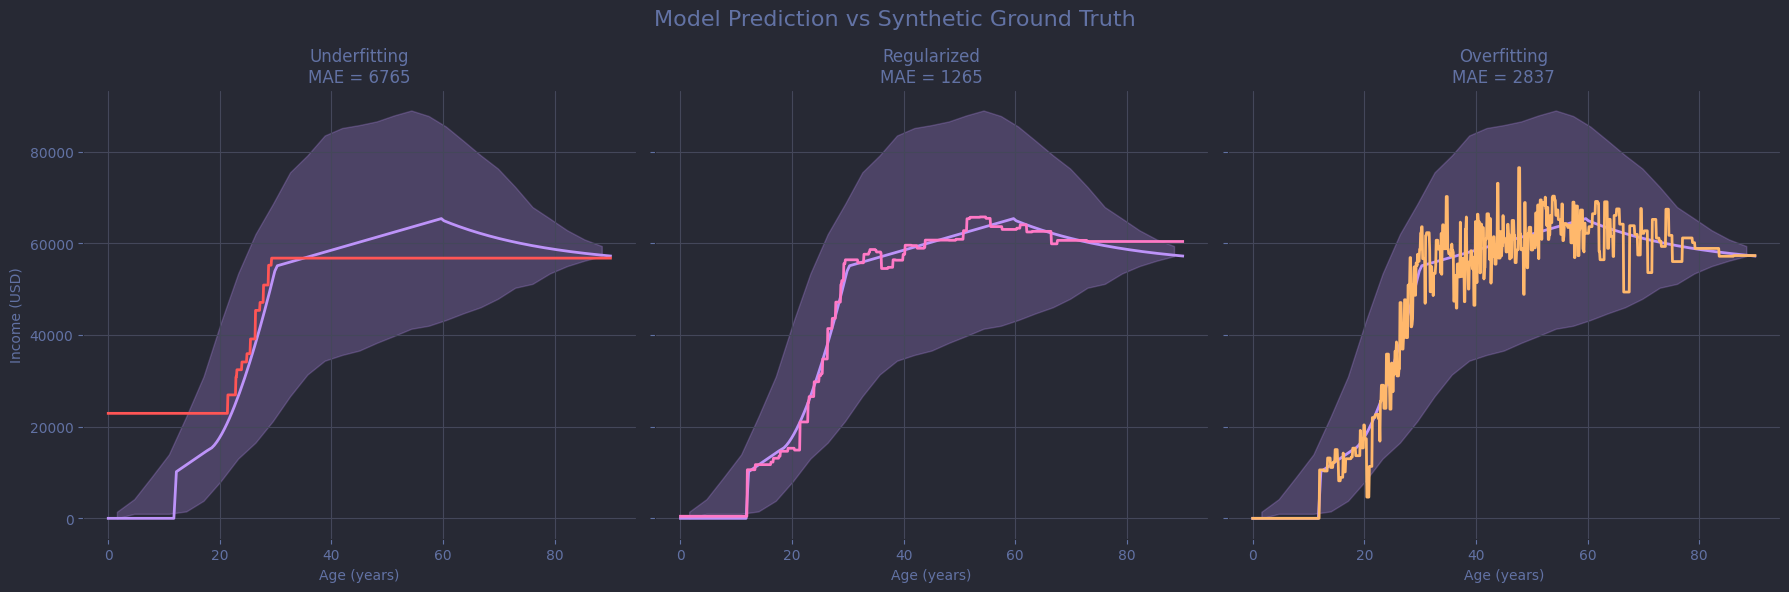

In [19]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

titles = ["Underfitting", "Regularized", "Overfitting"]
predictions = [
    predicted_incomes_underfit,
    predicted_incomes_regularized,
    predicted_incomes_overfit
]
colors = [COL_Red, COL_Pink, COL_Orange]
maes = [mae_underfit, mae_regularized, mae_overfit]

for ax, title, prediction, color, mae in zip(axes, titles, predictions, colors, maes):
    ax.plot(age_synthetic, income_synthetic, label="Synthetic Curve", color=COL_Purple, linewidth=2)
    ax.fill_between(bin_centers, bin_min_smooth, bin_max_smooth, color=COL_Purple, alpha=0.25, label="Training Range")
    ax.plot(ages_to_predict, prediction, label="Model Prediction", color=color, linewidth=2)
    ax.set_title(f"{title}\nMAE = {mae:.0f}")
    ax.set_xlabel("Age (years)")
    ax.grid(True)

axes[0].set_ylabel("Income (USD)")

fig.suptitle("Model Prediction vs Synthetic Ground Truth", fontsize=16)
plt.tight_layout()
plt.savefig('lgbm_fit_compared.png')
plt.show()

## Pretrain models for interactive plot

In [20]:
ages_to_predict = np.linspace(0, 90, 200)
income_without_noise = [income(age) for age in ages_to_predict]

param_grid = {
    'num_leaves': [2, 4, 8, 16, 32, 64, 128, 256],
    'min_data_in_leaf': [1, 10, 20, 25, 30, 50],
    'lambda_l2': [0, 10, 50],
    'num_iterations': [25, 50, 100, 125, 150, 200, 500, 1000],
    'learning_rate': [0.5, 0.1, 0.05]
}
total_iter = np.prod([len(v) for v in param_grid.values()])

predictions = {
    "keys": [],
    "values": [],
    "maes": []
}

for nl, mdl, l2, n_iter, lr in tqdm(product(
    param_grid['num_leaves'],
    param_grid['min_data_in_leaf'],
    param_grid['lambda_l2'],
    param_grid['num_iterations'],
    param_grid['learning_rate']
), total=total_iter):
    params = common_params | {
        'num_leaves': nl,
        'min_data_in_leaf': mdl,
        'lambda_l2': l2,
        'num_iterations': n_iter,
        'learning_rate': lr
    }
    model = lgb.train(params, train_dataset)
    preds = model.predict(ages_to_predict.reshape(-1, 1))
    
    key = f'{nl}_{mdl}_{l2}_{n_iter}_{lr}'
    predictions["keys"].append(key)
    predictions["values"].append(preds.astype(np.int32).tolist())
    predictions["maes"].append(mean_absolute_error(income_without_noise, preds))

with gzip.open("predictions.json.gz", "wt", encoding="utf-8") as f:
    json.dump(predictions, f)

  0%|          | 0/3456 [00:00<?, ?it/s]

## Update template html for interactive plot

In [122]:
with open("interactive_plot_template.html", "r", encoding="utf-8") as f:
    template = f.read()

replacements = {
    "{{param_grid_json}}": json.dumps(param_grid),
    "{{ages_json}}": json.dumps(ages_to_predict.tolist()),
    "{{true_income_json}}": json.dumps(income_synthetic),
    "{{default_values_json}}": json.dumps(default_values),
    "{{default_key}}": default_key,
    "{{bin_centers_json}}": json.dumps(bin_centers.tolist()),
    "{{bin_min_smooth_json}}": json.dumps(bin_min_smooth.tolist()),
    "{{bin_max_smooth_json}}": json.dumps(bin_max_smooth.tolist())
}

for placeholder, value in replacements.items():
    template = template.replace(placeholder, value)

with open("interactive_plot.html", "w", encoding="utf-8") as f:
    f.write(template)

In [21]:
!jupyter nbconvert --to script 'Overfitting.ipynb'

[NbConvertApp] Converting notebook Overfitting.ipynb to script
[NbConvertApp] Writing 14187 bytes to Overfitting.py
